# <center>German apartment listings over time</center>


## 0) Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from timeit import default_timer as timer

import glob
import concurrent.futures
import torch

import dataprocessing as dp

%load_ext nb_black
%matplotlib inline

plt.rcParams["figure.dpi"] = 130
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", None)

Matplotlib is building the font cache; this may take a moment.


<IPython.core.display.Javascript object>

## 1) Data Preprocessing

#### find dates:

In [2]:
dates = sorted(
    [
        s[s.find("mieten") + len("mieten") : s.rfind(".csv")]
        for s in glob.glob("../data/mieten*")
    ]
)

<IPython.core.display.Javascript object>

#### load time series dataframe with multithreading:

In [3]:
start = timer()
with concurrent.futures.ThreadPoolExecutor() as executor:
    combined_dfs = executor.map(dp.create_combined_df, dates)

time_df = pd.concat(combined_dfs, axis=1)
time_df = time_df.replace([np.inf, -np.inf], np.nan)
time_df = time_df.dropna()

finish = timer()
print(f"Loaded in {round(finish-start, 2)} seconds")

Loaded in 97.64 seconds


<IPython.core.display.Javascript object>

#### compute change between dates:

In [4]:
startdate = dates[0]
enddate = dates[-1]
cols = [
    "median_yearly_roi",
    "median_rent_m2",
    "num_rent",
    "median_price_m2",
    "num_sale",
]

for col in cols:
    time_df[f"{col} change"] = dp.compute_change(time_df, col, startdate, enddate)
move_cols = [f"{col} change" for col in cols]
time_df = time_df[move_cols + [col for col in time_df.columns if col not in move_cols]]

<IPython.core.display.Javascript object>

## 2) Predicting rents and saleprices with a RNN - to be implemented

## 3) Results

### 3.1) Overview

In [5]:
min_num = 3
startdate = dates[0]
enddate = dates[-1]

time_filt = (
    (time_df["num_rent " + startdate] > min_num)
    & (time_df["num_rent " + enddate] > min_num)
    & (time_df["num_sale " + startdate] > min_num)
    & (time_df["num_sale " + enddate] > min_num)
)

time_df[time_filt].sort_values("median_yearly_roi change", ascending=False).head(5)

,median_yearly_roi change,median_rent_m2 change,num_rent change,median_price_m2 change,num_sale change,median_yearly_roi 2020-04-07,median_rent_m2 2020-04-07,num_rent 2020-04-07,median_price_m2 2020-04-07,num_sale 2020-04-07,median_yearly_roi 2020-04-13,median_rent_m2 2020-04-13,num_rent 2020-04-13,median_price_m2 2020-04-13,num_sale 2020-04-13,median_yearly_roi 2020-04-19,median_rent_m2 2020-04-19,num_rent 2020-04-19,median_price_m2 2020-04-19,num_sale 2020-04-19,median_yearly_roi 2020-04-28,median_rent_m2 2020-04-28,num_rent 2020-04-28,median_price_m2 2020-04-28,num_sale 2020-04-28,median_yearly_roi 2020-05-04,median_rent_m2 2020-05-04,num_rent 2020-05-04,median_price_m2 2020-05-04,num_sale 2020-05-04,median_yearly_roi 2020-05-10,median_rent_m2 2020-05-10,num_rent 2020-05-10,median_price_m2 2020-05-10,num_sale 2020-05-10,median_yearly_roi 2020-05-19,median_rent_m2 2020-05-19,num_rent 2020-05-19,median_price_m2 2020-05-19,num_sale 2020-05-19,median_yearly_roi 2020-05-25,median_rent_m2 2020-05-25,num_rent 2020-05-25,median_price_m2 2020-05-25,num_sale 2020-05-25,median_yearly_roi 2020-06-01,median_rent_m2 2020-06-01,num_rent 2020-06-01,median_price_m2 2020-06-01,num_sale 2020-06-01,median_yearly_roi 2020-06-08,median_rent_m2 2020-06-08,num_rent 2020-06-08,median_price_m2 2020-06-08,num_sale 2020-06-08,median_yearly_roi 2020-06-15,median_rent_m2 2020-06-15,num_rent 2020-06-15,median_price_m2 2020-06-15,num_sale 2020-06-15,median_yearly_roi 2020-06-22,median_rent_m2 2020-06-22,num_rent 2020-06-22,median_price_m2 2020-06-22,num_sale 2020-06-22,median_yearly_roi 2020-06-29,median_rent_m2 2020-06-29,num_rent 2020-06-29,median_price_m2 2020-06-29,num_sale 2020-06-29,median_yearly_roi 2020-07-06,median_rent_m2 2020-07-06,num_rent 2020-07-06,median_price_m2 2020-07-06,num_sale 2020-07-06,median_yearly_roi 2020-07-13,median_rent_m2 2020-07-13,num_rent 2020-07-13,median_price_m2 2020-07-13,num_sale 2020-07-13,median_yearly_roi 2020-07-20,median_rent_m2 2020-07-20,num_rent 2020-07-20,median_price_m2 2020-07-20,num_sale 2020-07-20
zipCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
47229,4.90,0.99,1.17,0.20,2.00,0.03,6.59,24.0,2811.97,5.0,0.03,6.38,29.0,2811.97,5.0,0.03,6.50,24.0,2811.97,5.0,0.05,6.09,23.0,1600.00,9.0,0.06,6.42,24.0,1322.29,10.0,0.06,6.23,24.0,1322.29,10.0,0.09,6.19,24.0,878.63,12.0,0.13,6.40,24.0,576.92,9.0,0.13,6.42,25.0,576.92,9.0,0.14,6.50,27.0,570.55,8.0,0.14,6.56,27.0,564.18,7.0,0.14,6.71,28.0,564.18,7.0,0.14,6.57,30.0,570.55,8.0,0.14,6.57,28.0,576.92,9.0,0.14,6.61,28.0,570.55,10.0,0.14,6.55,28.0,570.55,10.0
41751,2.57,1.38,0.54,0.53,1.17,0.03,5.68,26.0,2510.03,6.0,0.03,5.71,24.0,2510.03,6.0,0.03,5.71,22.0,2593.96,5.0,0.03,5.78,26.0,2593.96,5.0,0.04,6.11,23.0,2147.50,6.0,0.03,6.04,24.0,2426.09,7.0,0.04,6.17,21.0,1701.03,11.0,0.05,6.24,21.0,1570.03,8.0,0.04,5.70,19.0,1570.03,8.0,0.05,6.24,26.0,1570.03,8.0,0.05,6.41,26.0,1570.03,8.0,0.04,6.16,27.0,1701.03,9.0,0.04,6.41,22.0,1889.08,8.0,0.03,5.73,22.0,2306.01,8.0,0.05,5.50,19.0,1439.02,7.0,0.07,7.83,14.0,1342.59,7.0
1665,2.27,1.08,0.67,0.48,0.36,0.03,6.04,18.0,2400.00,22.0,0.03,6.09,17.0,2400.00,22.0,0.03,6.00,17.0,2400.00,22.0,0.03,6.00,21.0,2400.00,22.0,0.03,6.14,20.0,2400.00,20.0,0.03,6.11,19.0,2400.00,23.0,0.03,6.13,20.0,2400.00,23.0,0.03,6.11,19.0,2400.00,23.0,0.03,6.19,15.0,2400.00,21.0,0.03,6.19,13.0,2400.00,19.0,0.06,6.25,14.0,1241.38,9.0,0.05,6.19,15.0,1438.85,11.0,0.05,6.15,14.0,1438.85,11.0,0.06,6.20,14.0,1170.18,8.0,0.06,6.11,13.0,1241.38,7.0,0.07,6.56,12.0,1153.48,8.0
25541,2.10,0.95,1.29,0.48,0.67,0.02,5.54,21.0,4054.96,6.0,0.05,5.91,23.0,2048.04,2.0,0.02,6.12,26.0,3115.02,3.0,0.02,6.20,29.0,3115.02,3.0,0.02,6.23,30.0,3115.02,3.0,0.02,6.14,27.0,3115.02,3.0,0.03,5.60,26.0,2174.49,4.0,0.04,6.14,27.0,2174.49,4.0,0.03,5.66,29.0,2174.49,4.0,0.03,5.26,27.0,2173.35,4.0,0.04,4.96,32.0,1488.19,5.0,0.04,5.00,31.0,1488.19,5.0,0.04,5.12,32.0,1488.19,5.0,0.04,5.23,31.0,1488.19,5.0,0.04,5.52,28.0,1488.19,5.0,0.03,5.28,27.0,1938.

<IPython.core.display.Javascript object>

#### select regions to further inspect:

In [6]:
regions = [72074]
time_df.loc[regions]

,median_yearly_roi change,median_rent_m2 change,num_rent change,median_price_m2 change,num_sale change,median_yearly_roi 2020-04-07,median_rent_m2 2020-04-07,num_rent 2020-04-07,median_price_m2 2020-04-07,num_sale 2020-04-07,median_yearly_roi 2020-04-13,median_rent_m2 2020-04-13,num_rent 2020-04-13,median_price_m2 2020-04-13,num_sale 2020-04-13,median_yearly_roi 2020-04-19,median_rent_m2 2020-04-19,num_rent 2020-04-19,median_price_m2 2020-04-19,num_sale 2020-04-19,median_yearly_roi 2020-04-28,median_rent_m2 2020-04-28,num_rent 2020-04-28,median_price_m2 2020-04-28,num_sale 2020-04-28,median_yearly_roi 2020-05-04,median_rent_m2 2020-05-04,num_rent 2020-05-04,median_price_m2 2020-05-04,num_sale 2020-05-04,median_yearly_roi 2020-05-10,median_rent_m2 2020-05-10,num_rent 2020-05-10,median_price_m2 2020-05-10,num_sale 2020-05-10,median_yearly_roi 2020-05-19,median_rent_m2 2020-05-19,num_rent 2020-05-19,median_price_m2 2020-05-19,num_sale 2020-05-19,median_yearly_roi 2020-05-25,median_rent_m2 2020-05-25,num_rent 2020-05-25,median_price_m2 2020-05-25,num_sale 2020-05-25,median_yearly_roi 2020-06-01,median_rent_m2 2020-06-01,num_rent 2020-06-01,median_price_m2 2020-06-01,num_sale 2020-06-01,median_yearly_roi 2020-06-08,median_rent_m2 2020-06-08,num_rent 2020-06-08,median_price_m2 2020-06-08,num_sale 2020-06-08,median_yearly_roi 2020-06-15,median_rent_m2 2020-06-15,num_rent 2020-06-15,median_price_m2 2020-06-15,num_sale 2020-06-15,median_yearly_roi 2020-06-22,median_rent_m2 2020-06-22,num_rent 2020-06-22,median_price_m2 2020-06-22,num_sale 2020-06-22,median_yearly_roi 2020-06-29,median_rent_m2 2020-06-29,num_rent 2020-06-29,median_price_m2 2020-06-29,num_sale 2020-06-29,median_yearly_roi 2020-07-06,median_rent_m2 2020-07-06,num_rent 2020-07-06,median_price_m2 2020-07-06,num_sale 2020-07-06,median_yearly_roi 2020-07-13,median_rent_m2 2020-07-13,num_rent 2020-07-13,median_price_m2 2020-07-13,num_sale 2020-07-13,median_yearly_roi 2020-07-20,median_rent_m2 2020-07-20,num_rent 2020-07-20,median_price_m2 2020-07-20,num_sale 2020-07-20
zipCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
72074,1.08,1.14,1.7,1.06,1.25,0.04,14.61,10.0,4675.85,4.0,0.03,13.78,11.0,4736.84,3.0,0.04,15.32,13.0,4736.84,3.0,0.04,14.47,17.0,4942.61,4.0,0.03,13.75,15.0,5148.39,3.0,0.03,14.67,11.0,5360.56,4.0,0.03,14.24,16.0,5572.73,5.0,0.03,14.14,12.0,5148.39,5.0,0.03,13.95,6.0,5148.39,3.0,0.03,13.82,8.0,4942.61,4.0,0.03,13.8,9.0,4845.84,4.0,0.03,13.9,12.0,4845.84,4.0,0.03,13.82,8.0,4954.84,3.0,0.03,12.5,15.0,4954.84,3.0,0.03,13.4,14.0,4954.84,3.0,0.04,16.67,17.0,4954.84,5.0


<IPython.core.display.Javascript object>

### 3.2) Apartments for rent

/Users/max/Documents/ARBEIT/Projekte/ApartmentListings/data_analysis/dataprocessing.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(x, rotation=90)


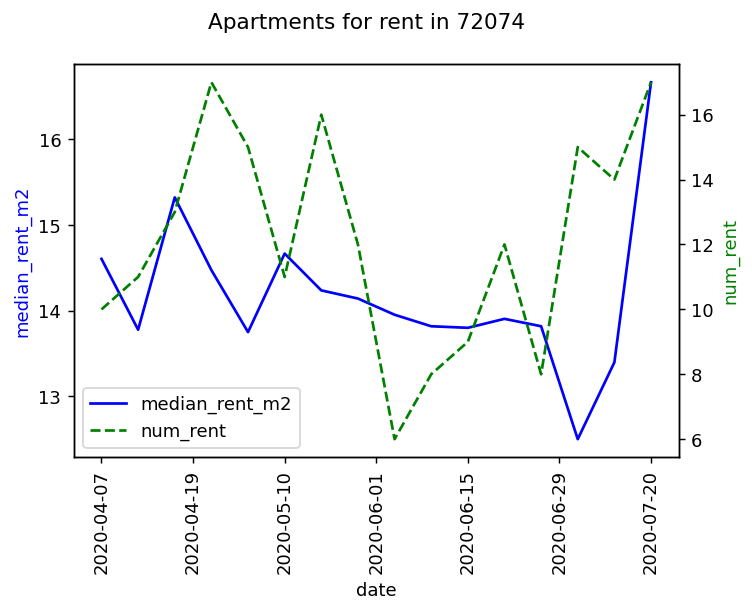

<IPython.core.display.Javascript object>

In [7]:
for attr in regions:
    dp.plot_2features(time_df, "rent", attr, dates, "median_rent_m2", "num_rent")

### 3.3) Apartments for sale

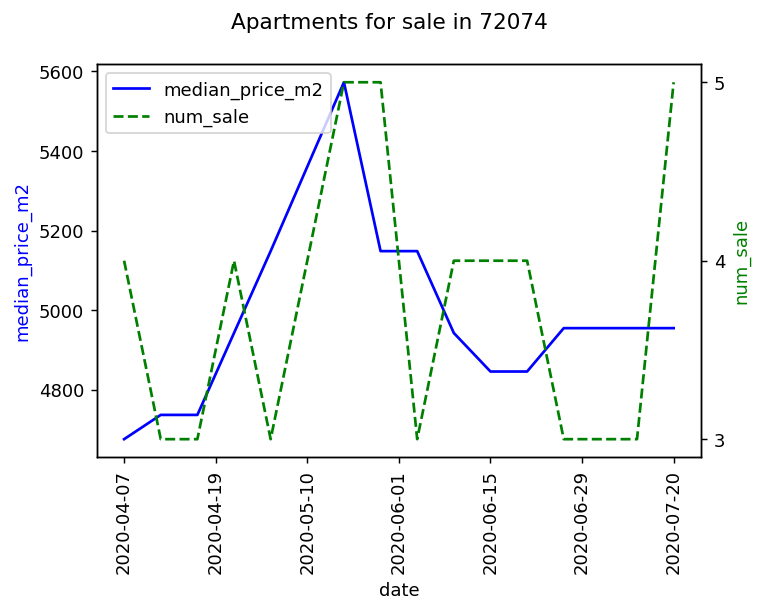

<IPython.core.display.Javascript object>

In [8]:
for attr in regions:
    dp.plot_2features(time_df, "sale", attr, dates, "median_price_m2", "num_sale")

### 3.4) Yearly rents divided by saleprice (return of investment - roi)

/Users/max/Documents/ARBEIT/Projekte/ApartmentListings/data_analysis/dataprocessing.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x, rotation=90)


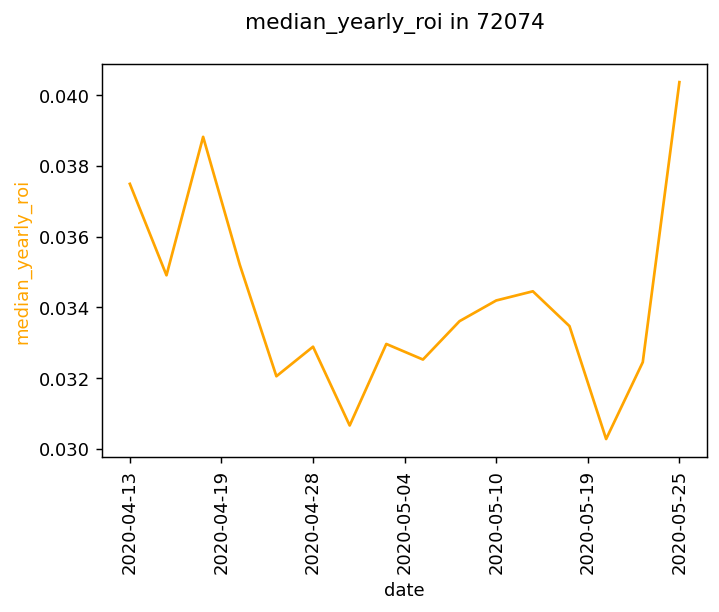

<IPython.core.display.Javascript object>

In [9]:
for attr in regions:
    dp.plot_1feature(time_df, attr, dates, "median_yearly_roi")